# Prueba técnica Go2Future

Importar drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importar imagen 3D

Leer la imagen con extension .gbl utilizando trimesh

In [ ]:
!pip install trimesh
import trimesh

In [ ]:
modelo_3d = trimesh.load("Taragui_500g.glb")

In [ ]:
modelo_3d.show()

Estuve intentando renderizar el archivo para obtener imagenes planas pero no pude hacerlo. Leyendo en foros dí con Blender aunque no lo utilicé ya que me facilitaron las imágenes para entrenar.

## Adecuación de imágenes mediante script

Se elimina el fondo y se recorta la ventana al tamaño del objeto target utilizando lal librería 'rembg' y 'PIL' para el procesamiento y visualización de imagenes.

In [ ]:
ruta_carpeta_imagenes = '/content/drive/MyDrive/images'


In [ ]:
import os
images = os.listdir(ruta_carpeta_imagenes)

In [ ]:
!pip install rembg

In [ ]:
from PIL import Image
from rembg import remove
import numpy as np
import os

ruta_salida = '/content/drive/MyDrive/images_procesadas'


if not os.path.exists(ruta_salida): # Crear el directorio de salida si no existe (ChatGPT)
    os.makedirs(ruta_salida)

images = os.listdir(ruta_carpeta_imagenes)
recorte_porcentaje = 0.17 # Le saco parte de arriba y abajo que pertenecen a estanterías

for image_name in images:

    image_path = os.path.join(ruta_carpeta_imagenes, image_name)# Leo la imagen

    output_image_path = os.path.join(ruta_salida, f'rembg_{image_name}') # Se genera el nombre de archivo de salida


    inp = Image.open(image_path)  # Abre la imagen con PIL


    width, height = inp.size
    recorte = int(height * recorte_porcentaje) # dimensiones para recortarla, se las especifico

    inp_recortada = inp.crop((0, recorte, width, height - recorte))


    output = remove(inp_recortada) # elimina el fondo con rembg

    output_array = np.array(output) # imagen procesada a matriz numpy

    # Transcripcion de GPT umbraliza el objeto para recortar la ventana y que quede sólo el objeto

    threshold = 50  # Umbral de transparencia para identificar píxeles del objeto
    objeto = np.where(output_array[:, :, -1] > threshold)  # Encontrar píxeles con transparencia mayor que el umbral

    # Recortar la imagen alrededor del objeto
    min_x, min_y = np.min(objeto[1]), np.min(objeto[0])
    max_x, max_y = np.max(objeto[1]), np.max(objeto[0])
    output_recortada = output.crop((min_x, min_y, max_x, max_y))

    # Guardar la imagen procesada y recortada
    output_recortada.save(output_image_path)


## Conformación del DataSet y etiquetado

Buscando la mejor manera de armar el conjunto de datos, encontré Roboflow, que de manera interactiva me permitió realizar la división de datos para entrenamiento y validación como también un etiquetado automático para las 1000 imágenes.


Realicé tres versiones de conjunto de datos, la primera con las imágenes procesadas en el paso anterior.


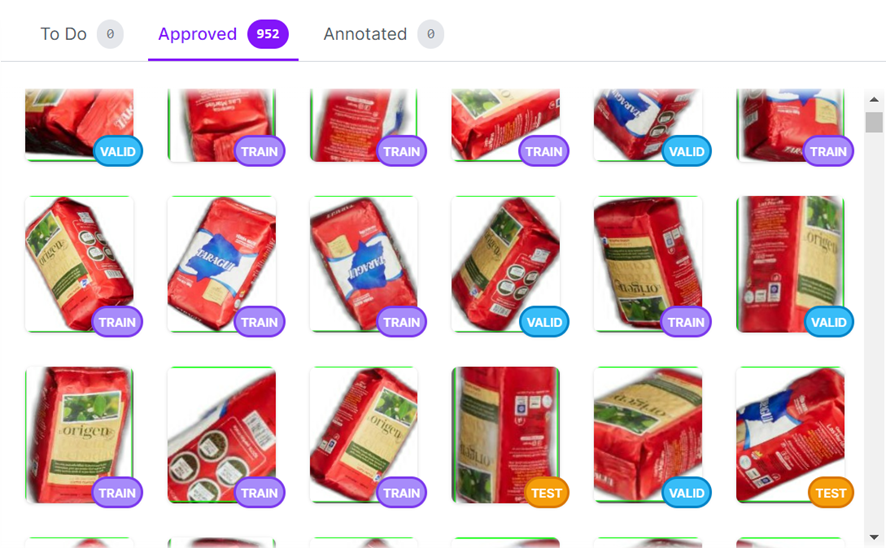

 Las otras con las imagenes crudas.

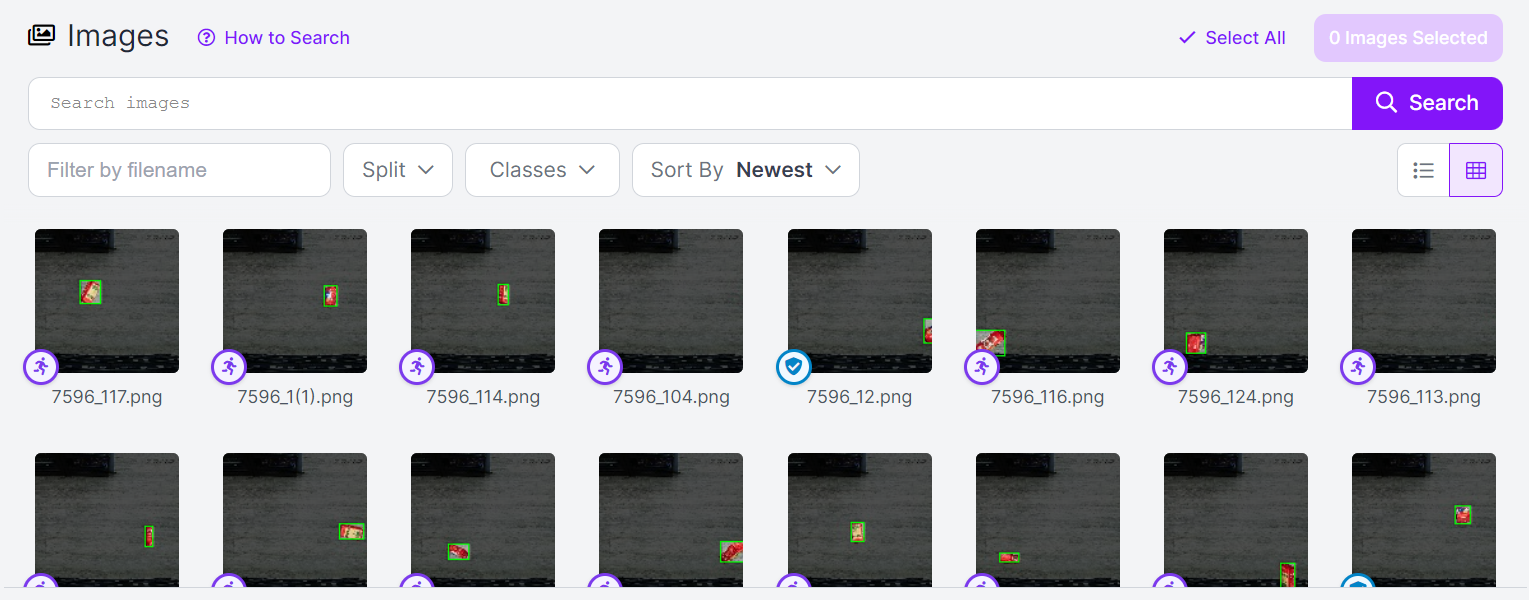

Una vez divididos los datos y etiquetas, se genera el Dataset. Se puede aplicar todo tipo de data augmentation de manera muy sencilla.

Roboflow genera un archivo con los datos de imagenes para train/val y un archivo data.yaml con los path para que el modelo YOLO ubique los archivos.

Se puede implementar con un fragmento decódigo que llama al conjunto de datos:

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SbrxJHqlYsOZZq7tvAwJ")
project = rf.workspace("santigarciamarzano").project("g2f_taragui500g")
version = project.version(1)
dataset = version.download("yolov8")


O bien directamente utilizando los archivos en el content de Colab o desde el drive.

## Entrenamiento del modelo

Utilizando ultralytics para importar modelos YOLO

La primer manera utilizada es llamar al modelo mediante un script

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 910.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
ROOT_DIR = '/content/drive/MyDrive/Modelo_3/data'

In [ ]:
import os
from ultralytics import YOLO
model = YOLO("yolov8m.pt")  # se cara el modelo preentrenado
results = model.train(data=os.path.join(ROOT_DIR, "data.yaml"), epochs=30)  # entrena con el data que generé de roboflow

La otra manera es utilizando los propios códigos generados por Roboflow que llama directamente al espacio de trabajo con una key unica.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

In [ ]:
from IPython.display import display, Image

In [ ]:
#MODELO_1
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SbrxJHqlYsOZZq7tvAwJ")
project = rf.workspace("santigarciamarzano").project("g2f_taragui500g")
version = project.version(2)
dataset = version.download("yolov8")

In [ ]:
#MODELO_2
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SbrxJHqlYsOZZq7tvAwJ")
project = rf.workspace("santigarciamarzano").project("g2f_taragui500g")
version = project.version(3)
dataset = version.download("yolov8")

Se entrenan 2 modelos que difieren en el conjunto de datos utilizado con la versión YOLOv8

In [ ]:
%cd {HOME} #Entrenamiento del modelo

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=22 imgsz=800 plots=True

Al terminar los entrenamientos, ambos modelos se guardan en sus respectivos archivos .pt (last.pt y best.pt)

In [ ]:
%cd {HOME} #Graficas de resultado
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

Del primer modelo con el dataset de imagenes procesadas

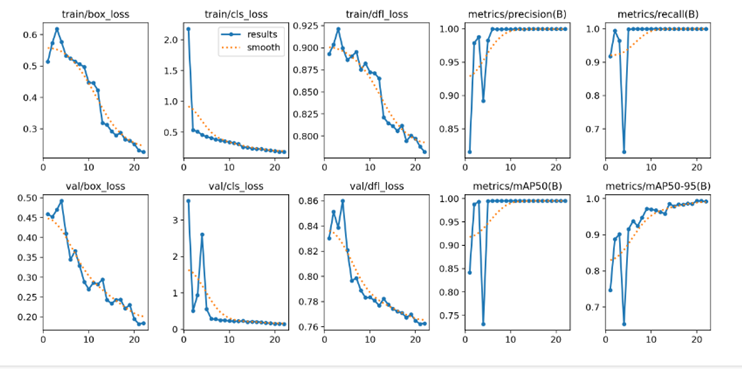

Del segundo modelo con imagenes crudas

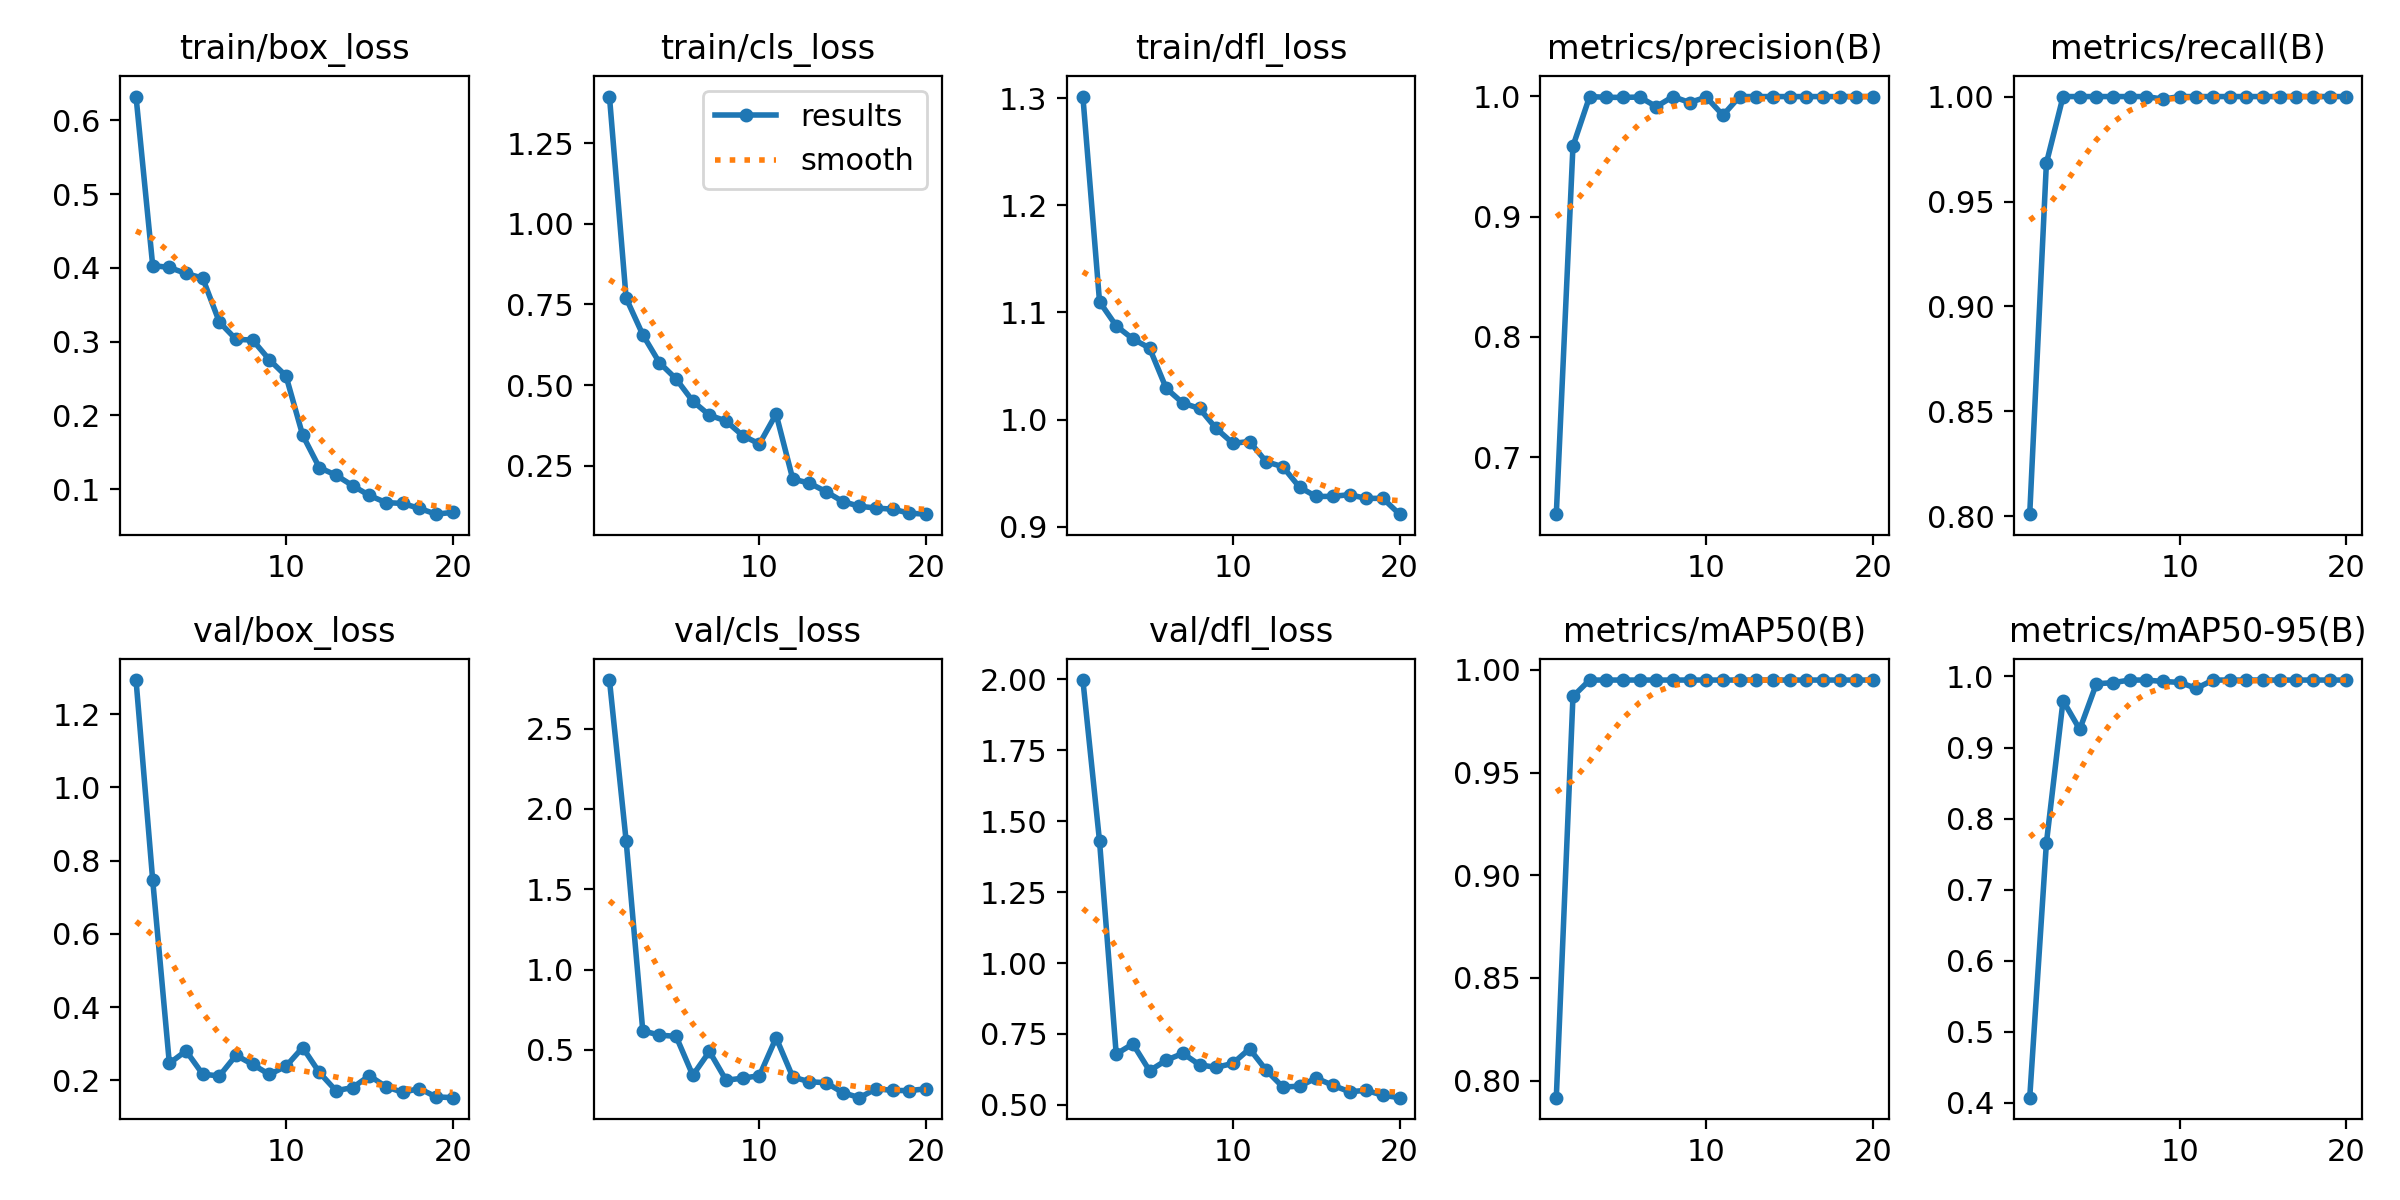

In [ ]:
%cd {HOME} #batch de prueba
Image(filename=f'{HOME}/runs/detect/train3/val_batch0_pred.jpg', width=600)

Primer modelo

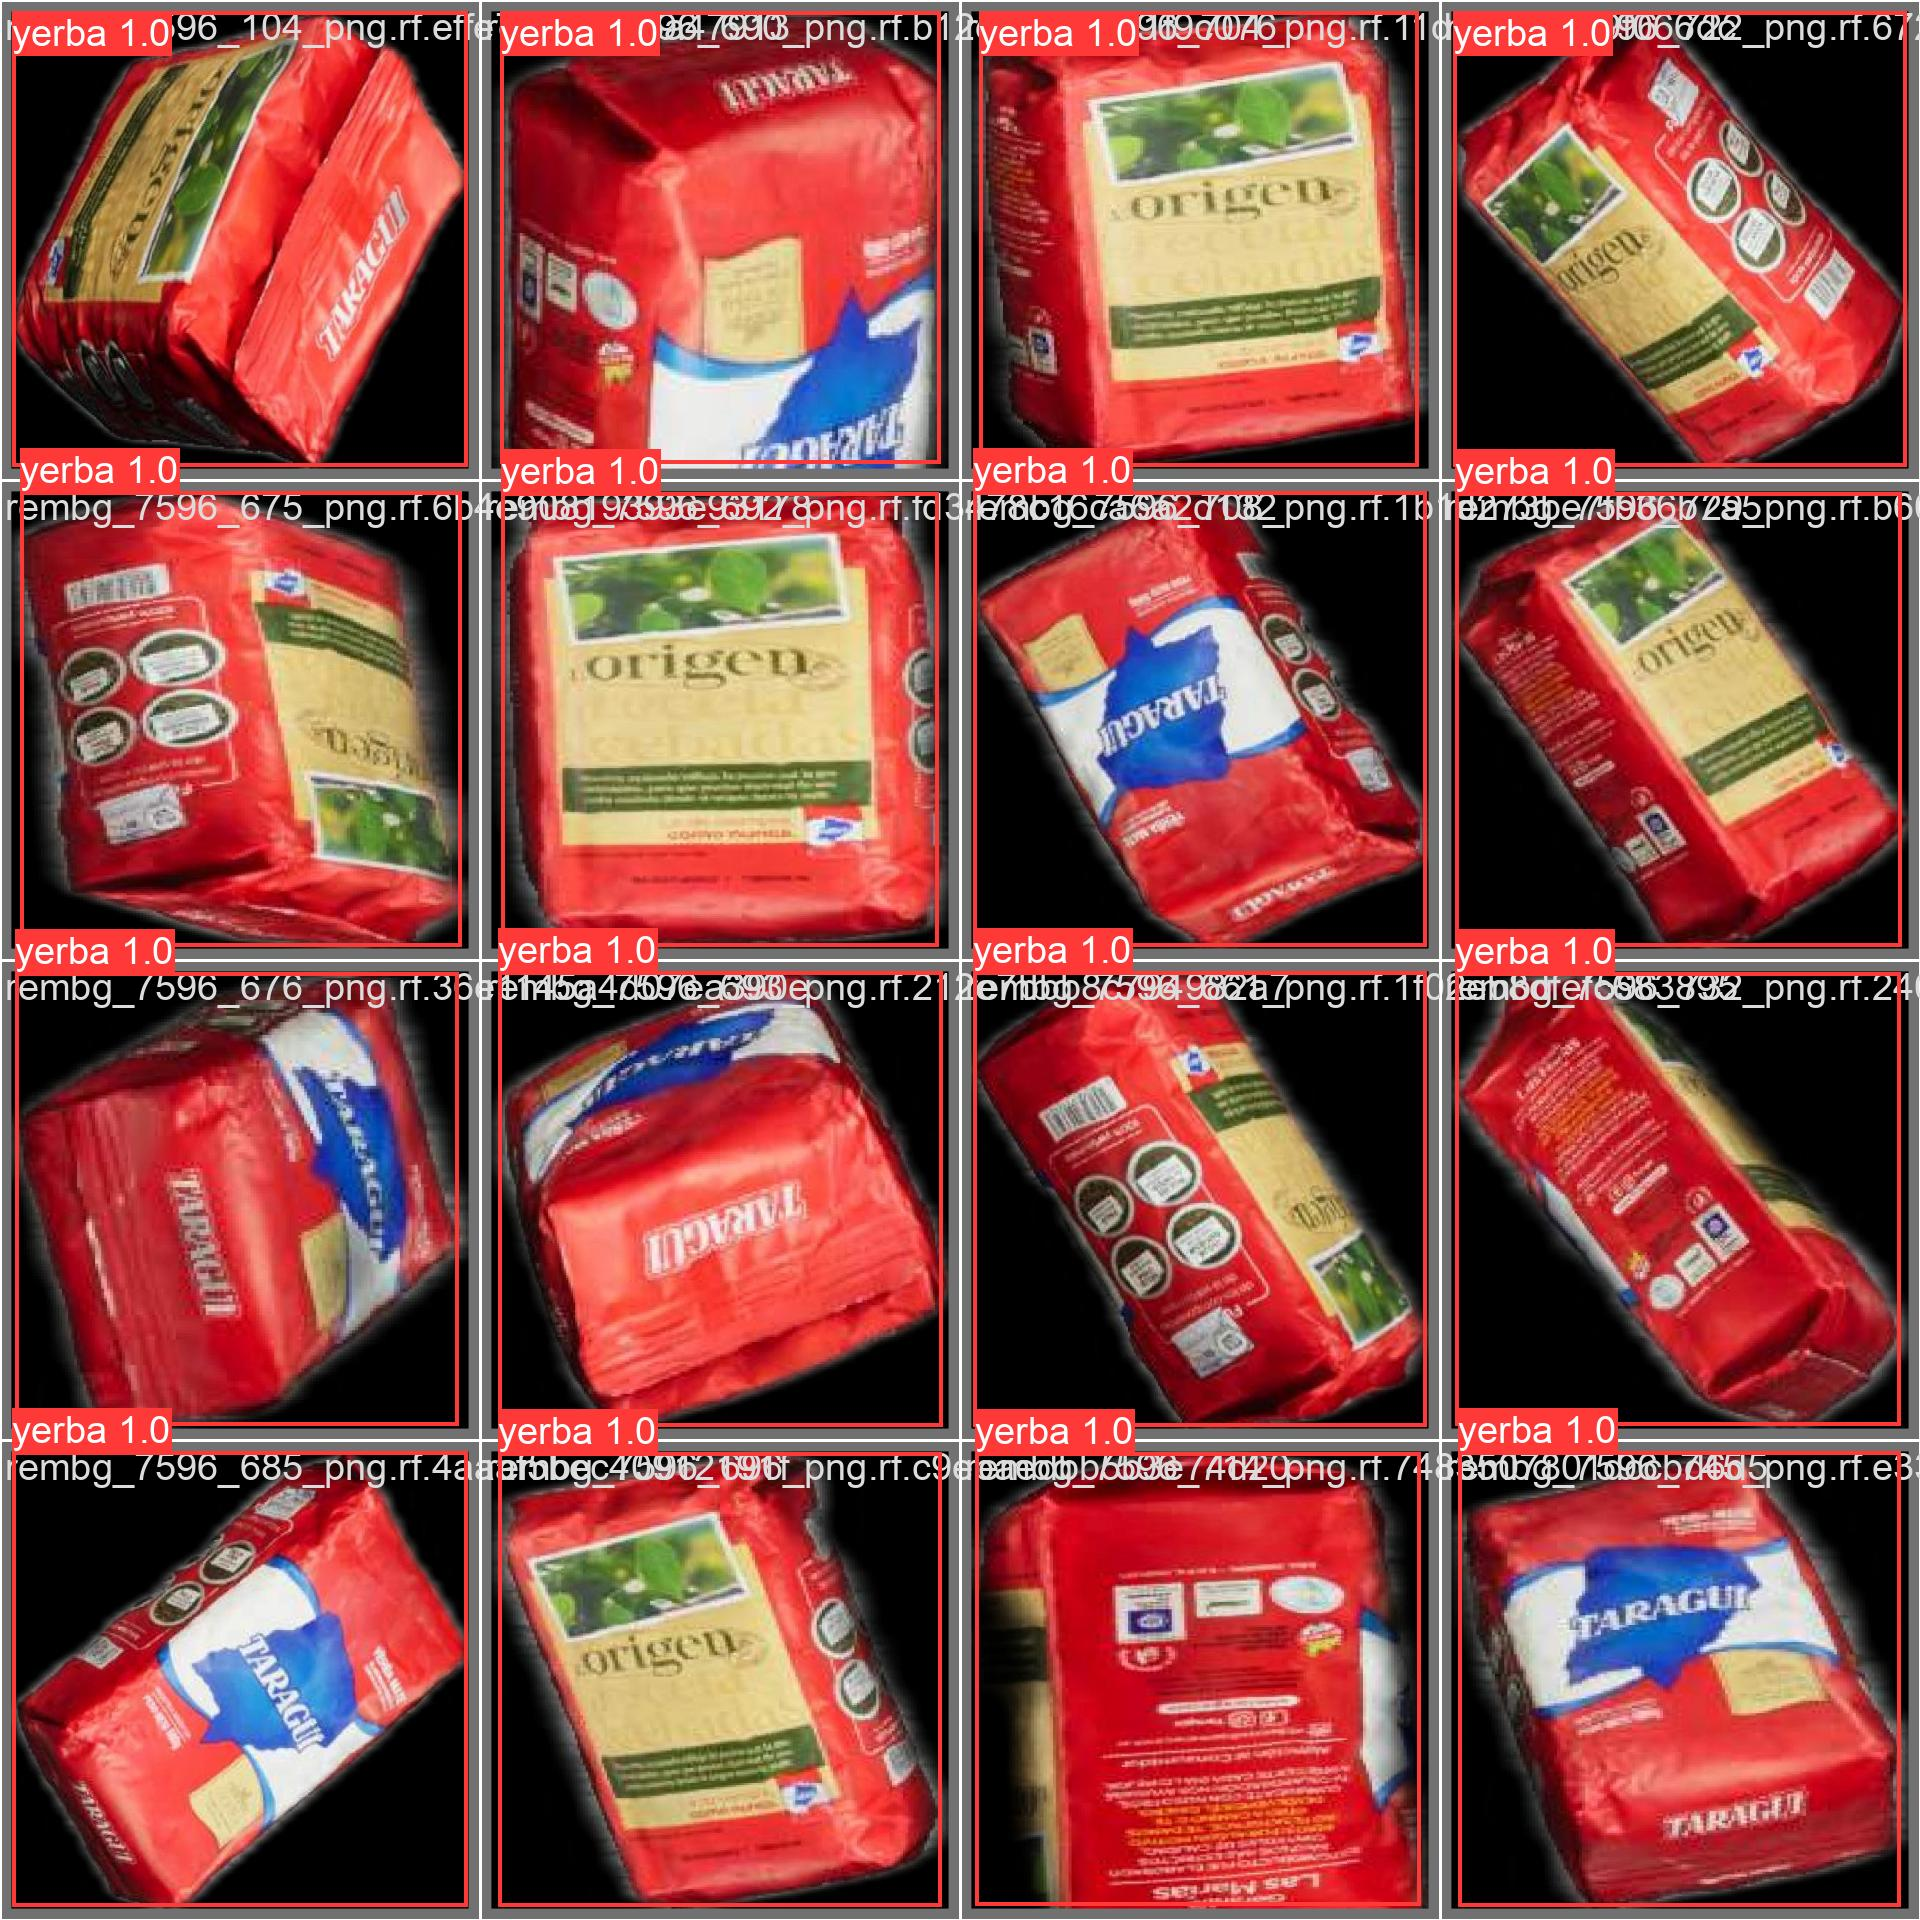

Segundo modelo

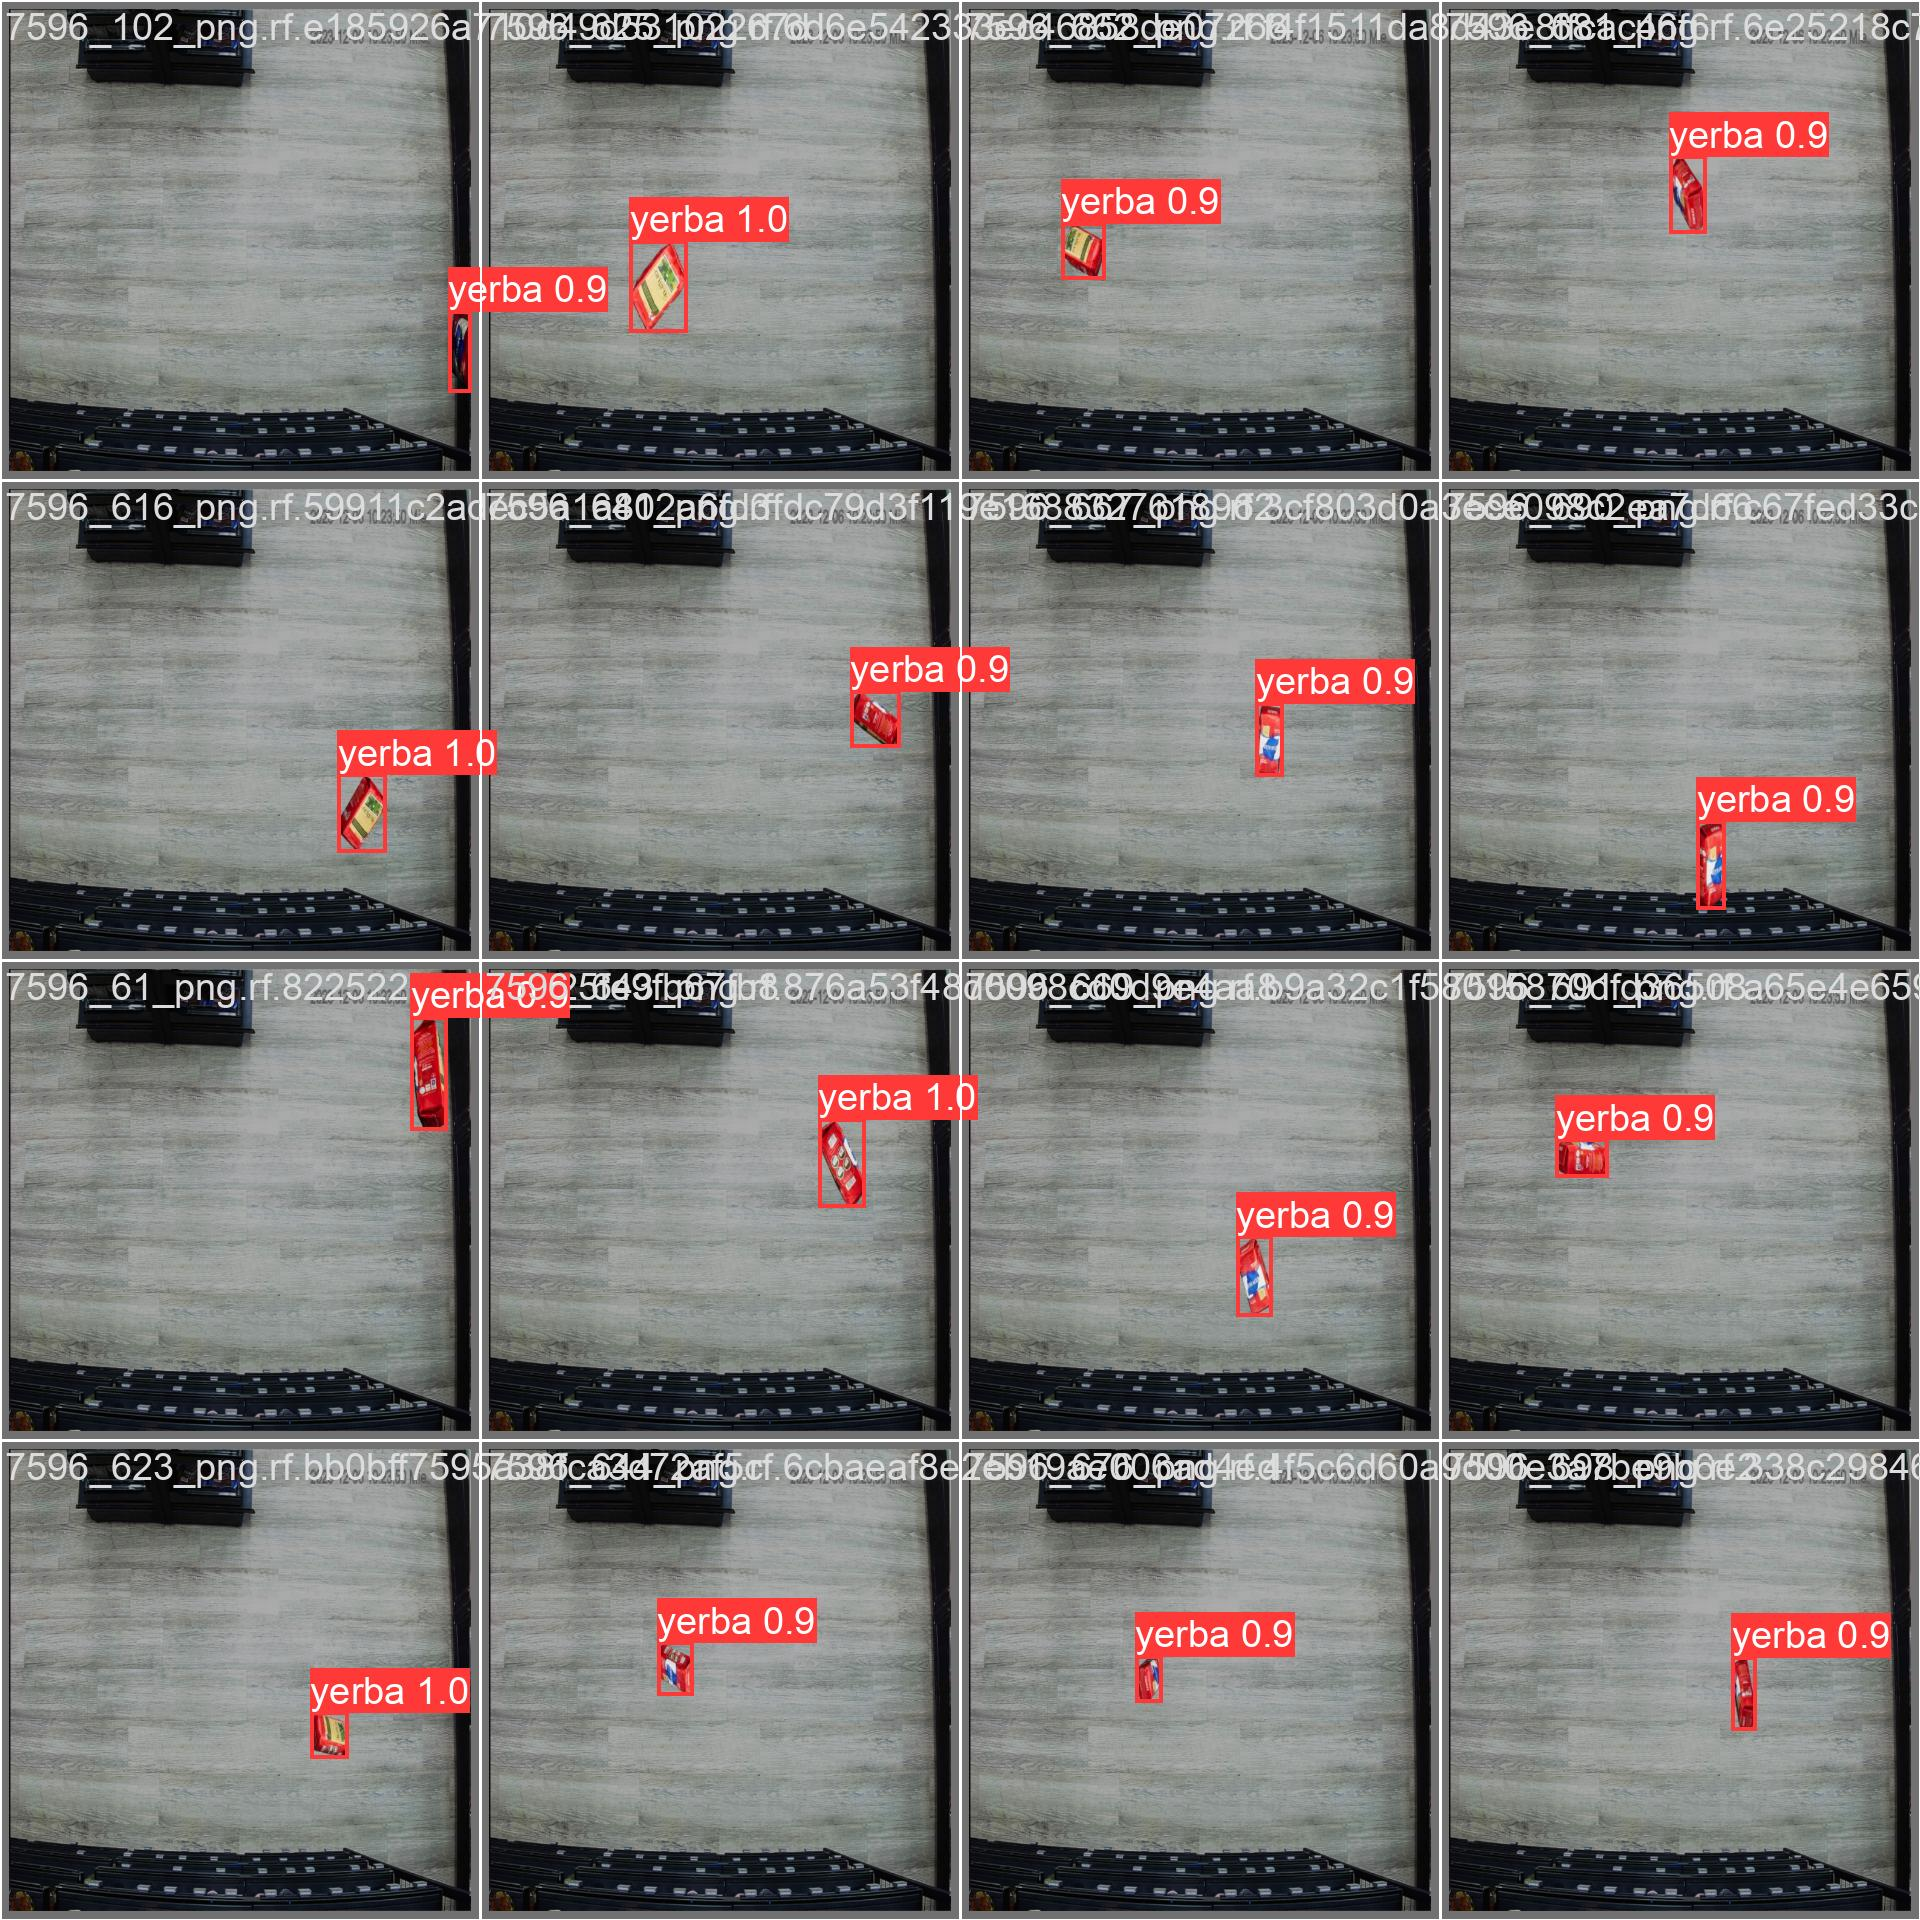

En la siguiente línea se realiza la tarea de detección, en modo validación.

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train3/weights/best.pt data={dataset.location}/data.yaml

Una detección en modo predicción en las imagenes de test.

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train3/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Se visualiza la detección del objeto en 3 imagenes del conjunto.

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

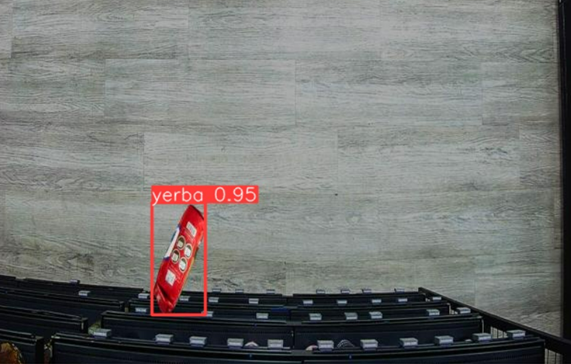

## Inferencia del modelo

En la siguiente línea se realiza la predicción para el video compartido. Está adjunto en el mail y se corresponde con el modelo numero 2 (imagenes crudas).

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train3/weights/best.pt conf=0.25 source=/content/Yerba_mate_taragui.mp4

Utilizando la librería cv2 se realiza la inferencia del mismo video pudiendo retocar los límites del bbox y otros parámetros. Se corresponde con el video adjunto del modelo numero 1 (imagenes preprocesadas).

In [ ]:
import cv2

VIDEO_PATH = '/content/21.Yerba mate taragui 500g.mp4'

video_path_out = '{}_out.mp4'.format(VIDEO_PATH)

cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
H, W, _ = frame.shape
out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

MODEL_PATH = '/content/runs/detect/train2/weights/best.pt'
model = YOLO(MODEL_PATH)  # cargar un modelo personalizado

threshold = 0.5

while ret:
    results = model(frame)[0]

    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result

        if score > threshold:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.putText(frame, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    out.write(frame)
    ret, frame = cap.read()

cap.release()
out.release()
cv2.destroyAllWindows()

Se puede hacer inferencia con el modelo  de Roboflow, la aplicación genera nuevamente un código para aplicar en el archivo deseado. Con la version paga, puede mostrar detalles de la evaluacion del modelo y posibles mejoras para optimización. Además permite utilizar el modelo para hacer inferencia de borde con NVIDIA Jetson.

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="jMNrS40fDgBsKxaW4IiR")
project = rf.workspace().project("yerba_detector")
model = project.version("1").model

job_id, signed_url, expire_time = model.predict_video(
    "YOUR_VIDEO.mp4",
    fps=5,
    prediction_type="batch-video",
)

results = model.poll_until_video_results(job_id)

print(results)

##  Conclusiones y mejoras

- Los modelos son funcionales y muestran métricas asociadas muy buenas. La inferencia no es óptima ya que se ve claramente que no detecta únicamente al objeto deseado en ambos modelos
- No hay diferencia notoria en métricas en cuanto a la utilización de imágenes preprocesadas o tomadas en crudo
- Para un buen funcionamiento hse debería realizar una mejora en el data augmentation. También durante el entrenamiento pueden modificarse parámetros del modelo YOLO e incluso utilizar diferentes modelos dentro de la misma versión
- Se debería probar inferencia con NVIDIA Jetson que nunca he utilizado y sólo alcancé a leer


Entrego el cuaderno dado el plazo del desafío. Voy a seguir probando éstas mejoras para obtener los resultados requeridos. Perdí mucho tiempo volviendo a estudiar un poco las herramientas utilizadas, pero ahora con todo funcionando es más fácil realizar pruebas y mejoras.
Me había alejado de los temas ya que en mi trabajo hago visión a más alto nivel, entrenando un software de clasificación y realizando el procesamiento de imágenes.
Me encantó volver a interiorizarme en la visión computarizada y me dió la certeza que quiero continuar en ésta dirección.
Gracias por la oportunidad!